In [1]:
# Need to do pip install rise to run this as a slide show

import matplotlib.pyplot as plt
%matplotlib inline
import networkx as nx
from networkx.algorithms import bipartite

# Identity Mapping

## Misty Nodine
## Data Architect, Spiceworks
## June 13, 2018

# Customer 360 View

A person has multiple identities
* A person has different identities related to email, login, browser usage, computer, …
* Also a person can use different browsers, use multiple devices, work in multiple locations, …


# Customer 360 View

Understanding a person means understanding what you see across all of that person’s identities
* Better targeting of advertisements and recommended content
* Avoid sending the same thing to multiple identities for the same person
* Better ability to track and understand customer behavior
* Better understanding of ROI for specific actions related to the customer

# Customer 360 View

A clean understanding how our identities relate improves company operational metrics
* Better count and characterization of visitors to our website
* Better predictability
* More comprehensive profiles especially of visitors who have not logged in
  * But needs to be understood as conjecture, not fact
* Because users typically touch your system through different means, this helps you understand how your business levers work

# Customer 360 View Building Blocks

When I am looking at these page, I see things that relate to multiple IDs - user ID, cookie ID, ad server ID

<img src=IdentityMappingPageView.png/> 

# Customer 360 View Building Blocks

Similarly on Amazon

<img src=IdentityMappingAmazonPageView.png/> 

# Customer 360 View Issues with Identifiers

No identifier is both always avaialble and very reliable.

\begin{array}{|l| l| l| l|}
\text{Identifier} & \text{Source} & \text{Reliability} & \text{Availability} \\\hline
\text{User ID} & \text{Registration and Login} & \text{High} & \text{Lower} \\
\text{Cookie ID} & \text{Cookie assigned by you} & \text{Lower} & \text{Always} \\
\text{Ad Server ID} & \text{Cookie assigned by ad server} & \text{Lower} & \text{High}
\end{array}

# Customer 360 View Issues with Identifiers

No identifier is both always avaialble and very reliable.

Reliable = The same person will always have the same identifier in the system of IDs.

| Identifier        | Source                       | Reliability  | Availability |
| ----------------- | -----------------------------| ------------ | -------------|
| User ID           | Registration & Login         | High         | Lower        |
| Cookie ID         | Cookie assigned by you       | Lower        | Always       |
| Ad Server ID      | Cookie assigned by ad server | Lower        | High         |

# Customer 360 View

Different information is tied to different identities
* User ID: Associated with your login
  * Set when the user registers
  * May be connected with user's profile information such as their job title
* Cookie ID: Associated with your browser
  * Set (if not there already) when you enter a browser session
  * Collects information such as what the web visitor looked at, what they clicked on, how they navigated through your website, where they came from
* Ad server ID: Associated with the ad server (e.g. Google DFP)
  * Set by the ad server
  * Collects information such as what ads the web visitor saw, whose ads they were, what they clicked on

# Outline

1. How to collect identity maps
2. Evaluating your identity map for cleanliness
3. Metadata use and ageing out IDs and ID maps
4. Fingerprint use
5. Cross-device identity mapping

In [2]:
def setColorsPositions(T):
    node_c = {'U': 'green', 'C': 'yellow', 'A': 'red'}
    node_colors = []

    node_x = {agent: idx for idx, agent in enumerate(['U', 'C', 'A'])}
    node_positions = dict()

    for node in T.nodes():
        node_type, node_val = node.split('_')
        node_colors.append(node_c.get(node_type, 'black'))
        node_positions[node] = (node_x.get(node_type, 3), int(node_val))
        
    return node_colors, node_positions

In [3]:
# 'Ideal' shape of graph
T = nx.Graph()
T.add_nodes_from(['U_1','U_2','U_3','U_4'])
T.add_nodes_from(['C_1','C_2','C_3', 'C_4','C_5','C_6', 'C_7','C_8'])
T.add_nodes_from(['A_2','A_3', 'A_4','A_5','A_6', 'A_7'])

T.add_edges_from([('U_1', 'C_1'), ('U_2', 'C_2'), ('U_3', 'C_3'), ('U_4', 'C_4')])
T.add_edges_from([('C_2', 'A_2'), ('C_3', 'A_3'), ('C_4', 'A_4'), ('C_5', 'A_5'), ('C_6', 'A_6'), ('C_7', 'A_7')])

node_colors_T, node_positions_T = setColorsPositions(T)

# Mapping Identity

We map identities using a graph, where the nodes represent an identity and the edges represent that we know the two identities 'relate to one another'
* Each type of identity is a different node type.
* Edges are undirected.
* Forms a multipartite graph, one part per ID type.

# Mapping Identity

What (ideally) would this look like?

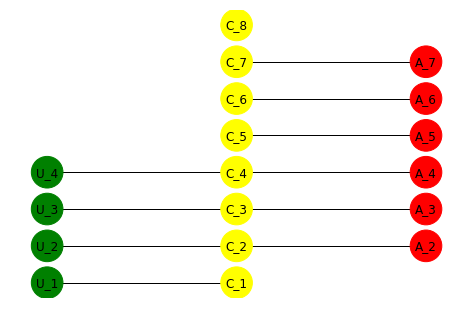

In [4]:
nx.draw(T, with_labels=True, node_size=1000, node_color=node_colors_T, pos = node_positions_T)

Note: You will never see an identity graph that looks like this in practice.

# How we create the graph: Through an event stream

* We keep track of normal events, e.g. Page Views.
* Events send with info on all known IDs of the sender.
* Pairs of IDs within a single event imply the existence of an edge.
  * For each such pair, an edge should exist in the graph between the ID pair
* Can update your identity map in real time.

In [5]:
# Sane user graph, where user may have multiple devices
UCg = nx.Graph()
UCg.add_nodes_from(['U_1','U_2', 'U_3'], bipartite=0)
UCg.add_nodes_from(['C_1','C_2','C_3', 'C_4','C_5','C_6', 'C_7','C_8'], bipartite=1)
UCg.add_edges_from([('U_1', 'C_1'), ('U_1', 'C_2'), ('U_2', 'C_3'), ('U_2', 'C_4'), ('U_3', 'C_5')])

node_colors_UCg, node_positions_UCg = setColorsPositions(UCg)

Good Graph: 


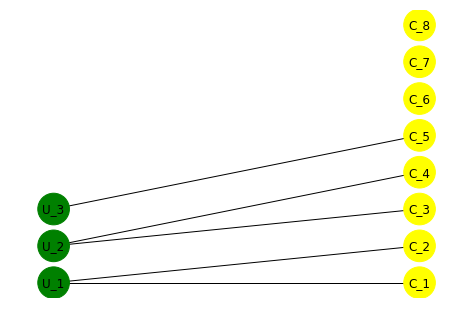

In [6]:
print "Good Graph: " 

nx.draw(UCg, with_labels=True, node_size=1000, node_color=node_colors_UCg, pos = node_positions_UCg)

In [7]:
# Bad user graph
UCb = nx.Graph()
UCb.add_nodes_from(['U_1','U_2', 'U_3', 'U_4', 'U_5'], bipartite=0)
UCb.add_nodes_from(['C_1','C_2','C_3', 'C_4','C_5','C_6', 'C_7', 'C_8', 'C_9', 'C_10', 'C_11', 'C_12', 'C_13'], bipartite=1)
UCb.add_edges_from([('U_1', 'C_1'), ('U_1', 'C_2'), ('U_2', 'C_2'), ('U_2', 'C_3'), 
                    ('U_3', 'C_3'), ('U_3', 'C_4'), ('U_4', 'C_5'), ('U_5', 'C_6')])

node_colors_UCb, node_positions_UCb = setColorsPositions(UCb)

Bad Graph: 


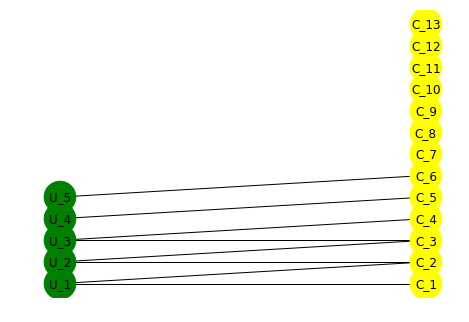

In [8]:
print "Bad Graph: "

nx.draw(UCb, with_labels=True, node_size=1000, node_color=node_colors_UCb, pos = node_positions_UCb)

# Evaluating your ID Graph

* In this case, we assume that each user has one login, so we should not see an ID from a cookie associated with more than one user ID.
* A user could have more than one ID from a cookie because they could have multiple devices, for instance.

# Evaluating your ID Graph

Degree of a Node = Number of edges incident on the node.

How do we evaluate the quality of the mapping?
* Average / min / max number of edges incident on each side
* For the user IDs may be multiple edges, may want to max out at some reasonable number of devices.
* For the IDs from the cookie want to see one only

In [9]:
user_good = dict(nx.degree(UCg, set(n for n,d in UCg.nodes(data=True) if d['bipartite']==0))).values()
cookie_good = dict(nx.degree(UCg, set(n for n,d in UCg.nodes(data=True) if d['bipartite']==1))).values()

print "Good graph: "
print "User ID degrees: max/ave/min =", max(user_good), '/',  \
                                        sum(user_good) / float(len(user_good)), '/', \
                                        min(user_good)
print "Cookie ID degrees: max/ave/min =", max(cookie_good), '/',  \
                                          sum(cookie_good) / float(len(cookie_good)), '/', \
                                          min(cookie_good)

user_bad = dict(nx.degree(UCb, set(n for n,d in UCb.nodes(data=True) if d['bipartite']==0))).values()
cookie_bad = dict(nx.degree(UCb, set(n for n,d in UCb.nodes(data=True) if d['bipartite']==1))).values()

print ""
print "Bad graph: "
print "User ID degrees: max/ave/min =", max(user_bad), '/',  \
                                        sum(user_bad) / float(len(user_bad)), '/', \
                                        min(user_bad)
print "Cookie ID degrees: max/ave/min =", max(cookie_bad), '/',  \
                                          sum(cookie_bad) / float(len(cookie_bad)), '/', \
                                          min(cookie_bad)

Good graph: 
User ID degrees: max/ave/min = 2 / 1.66666666667 / 1
Cookie ID degrees: max/ave/min = 1 / 0.625 / 0

Bad graph: 
User ID degrees: max/ave/min = 2 / 1.6 / 1
Cookie ID degrees: max/ave/min = 2 / 0.615384615385 / 0


# Using Connected Components

In graph theory, a connected component of an undirected graph is a subgraph 
in which any two vertices are connected to each other by paths, 
and which is connected to no additional vertices in the supergraph.
Finding the connected components is basically a depth-first search algorithm.

This graph has six connected components.

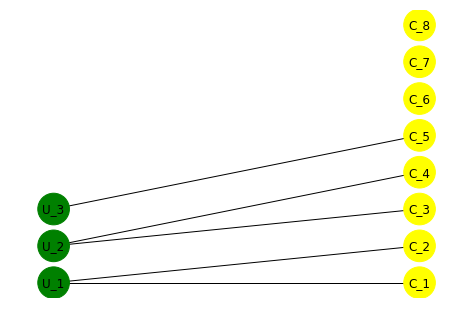

In [10]:
nx.draw(UCg, with_labels=True, node_size=1000, node_color=node_colors_UCg, pos = node_positions_UCg)

# Using Connected Components to Evaluate (User ID Perspective)

* Edges in the graph imply the two IDs relate to the same person
* In this particular situation, we assume that the login identifier (user_id) maps cleanly to a person
* If there is a connected component in the bipartite graph, that spans (in this case) multiple users, then we likely have some people confused with each other.

In [11]:
def get_components(G):
    [c for c in sorted(nx.connected_components(UCg), key=len, reverse=True)]
    
def num_users(component):
    return len([i for i in component if i.startswith('U')])

def component_users(G):
    return sorted([num_users(c) for c in nx.connected_components(G)], reverse=True)

In [12]:
print "Good graph: ", component_users(UCg)

Good graph:  [1, 1, 1, 0, 0, 0]


In [13]:
print "Bad graph: ", component_users(UCb)

Bad graph:  [3, 1, 1, 0, 0, 0, 0, 0, 0, 0]


# Using Connected Components to Evaluate (Cookie ID Perspective)

* Proliferation of cookie IDs for the same user is also bad

In [14]:
UCx = nx.Graph()

UCx.add_nodes_from(['U_1','U_2'], bipartite=0)
UCx.add_nodes_from(['C_1','C_2','C_3', 'C_4','C_5','C_6', 'C_7','C_8', 'C_9','C_10'], bipartite=1)
UCx.add_edges_from([('U_1', 'C_1'), ('U_2', 'C_2'), ('U_2', 'C_3'), ('U_2', 'C_4'), 
                    ('U_2', 'C_5'), ('U_2', 'C_6'), ('U_2', 'C_7'), ('U_2', 'C_8'), ('U_2', 'C_9')])

node_colors_UCx, node_positions_UCx = setColorsPositions(UCx)

Bushy Graph: 


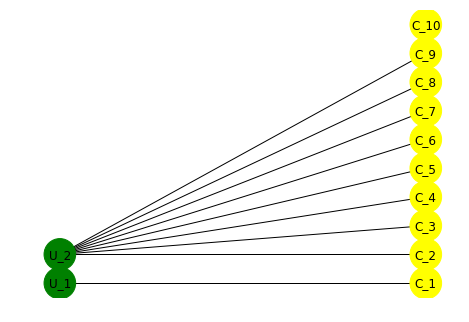

In [15]:
print "Bushy Graph: "

nx.draw(UCx, with_labels=True, node_size=1000, node_color=node_colors_UCx, pos = node_positions_UCx)

In [16]:
user_bushy = dict(nx.degree(UCx, set(n for n,d in UCx.nodes(data=True) if d['bipartite']==0))).values()
cookie_bushy = dict(nx.degree(UCx, set(n for n,d in UCx.nodes(data=True) if d['bipartite']==1))).values()

print "Bushy graph: "
print "User ID degrees: max/ave/min =", max(user_bushy), '/',  \
                                        sum(user_bushy) / float(len(user_bushy)), '/', \
                                        min(user_bushy)
print "Cookie ID degrees: max/ave/min =", max(cookie_bushy), '/',  \
                                          sum(cookie_bushy) / float(len(cookie_bushy)), '/', \
                                          min(cookie_bushy)

Bushy graph: 
User ID degrees: max/ave/min = 8 / 4.5 / 1
Cookie ID degrees: max/ave/min = 1 / 0.9 / 0


In [17]:
def num_cookies(component):
    return len([i for i in component if i.startswith('C')])

def component_cookies(G):
    return sorted([num_cookies(c) for c in nx.connected_components(G)], reverse=True)

In [18]:
print component_users(UCx)
print component_cookies(UCx)

[1, 1, 0]
[8, 1, 1]


# Cleanness in Cookie ID assignment

Here, the issue is with the cookie IDs, how clean are they?
* A single source for assigning cookie IDs can check that the same cookie ID is not assigned to multiple users.
* Problems occur when multiple users share the same computer.
* Cookies could be reassigned more frequently than they need to be assigned.

# Improving our Graph through Edge Metadata

We are observing an edge every time we get a page view that matches both the user ID and the cookie ID on the endpoints.

Keep data on how recently we have observed the edge
* Update a last_date_seen on the edge every time we observe the edges.
* Age out edges that we have not observed recently enough.
* Can combine this with a count of how many times we have observed the edge.

Use weighted edges
* Each time we observe an edge, we add 1 to its weight.
* Every day we decay the weight by some exponential decay factor.
* Remove edges when their weight falls below a predetermined threshold.

# Merging Cookie IDs Using Fingerprinting

Each time a user starts a browser session, use characteristics of the user to determine whether you should assign a new cookie ID or reassign an existing one
* Browser characteristics (from the browser's useragent): Browser family, Browser version, Computer OS family, Computer OS version, Device family, Device brand, Device model, Country, Locale
* Using the IP address the person is using you can get: Country, City, Postal code, DMA code, Area code, Region, Organization, ISP flag, Containing IP range

Some of this information is more stable than others. Identify a stable and sufficiently distinguishing set. This becomes the user fingerprint.


# Merging Cookie IDs Using Fingerprinting

When we see a user without a cookie ID:
1. Pull the fingerprint information for the user.
1. Check if we have seen that fingerprint before. If so, reassign the same cookie ID you assigned last time.
1. Otherwise, assign a new, unique cookie ID.

At Spiceworks, adding a single, fingerprint-based service for assignment of cookie IDs led to an improvement in the number of extra user IDs per connected component by about 54%.

# Incorporating Additional IDs

Also look at a different method for creating edges in our graph.

# How we expand the graph: Through cookie matching

* Process to match an ad server ID to your cookie ID using the browser.
  * You set your cookie in your domain, they set their cookie in their domain. 
  * The security model of the browser restricts one party from reading the cookie set by another party.
  * Cookie matching uses markup, pixels and redirects to enable it to communicate with you enough to map the IDs.
* Google has a good explanation for cookie matching at https://developers.google.com/ad-exchange/rtb/cookie-guide.
* The result of the cookie matching process is that your application has a match table between the two identifiers.
* Can just batch import the resulting match table or can update the graph in real time as matches are found (e.g. using an event stream).

# Advertisers and Cookie IDs

Here is our Page View, it has an advertisement. When an advertisement shows, we know we have a cookie match between the cookie ID and the advertiser's ID.

<img src=IdentityMappingPageView.png/>


# Cleanliness in the Cookie ID to Ad Server ID Mapping

* Because of the way the Cookie IDs and Ad server IDs are collected, processes for ageing out IDs and edges in the graph may be different.
  


# Cross-Device Identity Mapping

# Cross-Device Identity Mapping Using User ID

The same person on different devices will have different cookie IDs, hopefully one per device. Cross-device identity matching tries to group a set of cookie IDs that belong to a single user.

* Assuming the cookie IDs use browser / device data as a part of their fingerprint
* You can assume that multiple cookie IDs have edges to a common User ID belong to the same person
* This can allow you to tie behavior that a user has on your system when not logged in to that user
* Very reliable method for cross-device matching but ...
* But ... most of the people that visit the website never become users, so have no user_id

# Cross-Device Identity Mapping Using Ad Server ID

The same person on different devices will have different cookie IDs, hopefully one per device. Cross-device identity matching tries to group a set of cookie IDs that belong to a single user.

* A second method is to rely on your ad server to do the matching and match with their ID.
  * Similar accuracy to using the User ID, but the ID is not your own
  * Bonus is that most cookie IDs can be matched to ad server IDs, unlike with User ID
* This is becoming harder in the era of privacy regulation, so may not always be possible.

# Cross-Device Identity Mapping Using Fingerprinting

This method does not use either the user ID or an ad server ID

* A third method is to use predictive models based on things like IP addresses, browsing patterns and device proximity to try to determine whether multiple devices belong to the same person. (Similar to fingerprinting, above)
  * Methods like this are used behind the scenes by the advertisers.
* This process is more complex, because the user will be on different devices, browsers, apps, ... 
  * Also, some types of user attributes will be observable from one device or app but not from another
* Looks at all the different attributes you can observe currently about your user and tries to match to know attributes of known users, e.g. using ML or similarity metrics
* Match is probabilistic

# Spiceworks is Hiring!!! : www.spiceworks.com/jobs

# My Contact Info :  mistyn@spiceworks.com